In [ ]:
#pip install --upgrade pip

In [ ]:
#pip install --upgrade absl-py

In [ ]:
#pip install --upgrade tensorflow

In [ ]:
#pip uninstall -y numpy

In [ ]:
#pip install numpy

In [ ]:
#pip install matplotlib

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

In [2]:
print(tf.__version__)

1.13.1


## 2 - Overview of the Problem set ##

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [3]:
import numpy as np
import h5py

In [4]:

def load_dataset():
    train_dataset = h5py.File('dataset_cats/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('dataset_cats/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [5]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with train_set_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).

Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images. 

y = [1], it's a 'cat' picture.


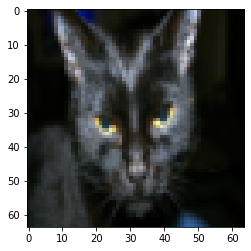

In [7]:
import matplotlib.pyplot as plt
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [8]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

**Exercise:** Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num\_px $*$ num\_px $*$ 3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [9]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(m_train, -1).T
test_set_x_flatten = test_set_x_orig.reshape(m_test, -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

Let's standardize our dataset.

In [10]:
train_set_x_t = (train_set_x_flatten/255).T
test_set_x_t = (test_set_x_flatten/255).T
train_set_y_t = train_set_y.T
test_set_y_t = test_set_y.T
print(f"train_set_x shape:{train_set_x_t.shape}")
print(f"train_set_y shape:{train_set_y_t.shape}")
print(f"test_set_x shape:{test_set_x_t.shape}")
print(f"test_set_y shape:{test_set_y_t.shape}")

train_set_x shape:(209, 12288)
train_set_y shape:(209, 1)
test_set_x shape:(50, 12288)
test_set_y shape:(50, 1)


In [11]:
from tensorflow.keras import layers

model = tf.keras.Sequential()
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.train.GradientDescentOptimizer(0.009),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model.fit(train_set_x_t, train_set_y_t, epochs=1000, batch_size=10, validation_data=(test_set_x_t, test_set_y_t))

Train on 209 samples, validate on 50 samples
Epoch 1/1000
209/209 [==============================] - 0s 165us/sample - loss: 0.0077 - acc: 1.0000 - val_loss: 1.5749 - val_acc: 0.7000
Epoch 2/1000
209/209 [==============================] - 0s 177us/sample - loss: 0.0079 - acc: 1.0000 - val_loss: 1.5448 - val_acc: 0.7200
Epoch 3/1000
209/209 [==============================] - 0s 183us/sample - loss: 0.0078 - acc: 1.0000 - val_loss: 1.5423 - val_acc: 0.7200
Epoch 4/1000
209/209 [==============================] - 0s 178us/sample - loss: 0.0078 - acc: 1.0000 - val_loss: 1.5393 - val_acc: 0.7200
Epoch 5/1000
209/209 [==============================] - 0s 196us/sample - loss: 0.0078 - acc: 1.0000 - val_loss: 1.5303 - val_acc: 0.7200
Epoch 6/1000
209/209 [==============================] - 0s 172us/sample - loss: 0.0079 - acc: 1.0000 - val_loss: 1.5558 - val_acc: 0.7200
Epoch 7/1000
209/209 [==============================] - 0s 182us/sample - loss: 0.0078 - acc: 1.0000 - val_loss: 1.5519 - val_a

Epoch 60/1000
209/209 [==============================] - 0s 165us/sample - loss: 0.0074 - acc: 1.0000 - val_loss: 1.5538 - val_acc: 0.7200
Epoch 61/1000
209/209 [==============================] - 0s 176us/sample - loss: 0.0074 - acc: 1.0000 - val_loss: 1.5588 - val_acc: 0.7200
Epoch 62/1000
209/209 [==============================] - 0s 176us/sample - loss: 0.0075 - acc: 1.0000 - val_loss: 1.5623 - val_acc: 0.7200
Epoch 63/1000
209/209 [==============================] - 0s 165us/sample - loss: 0.0074 - acc: 1.0000 - val_loss: 1.5382 - val_acc: 0.7200
Epoch 64/1000
209/209 [==============================] - 0s 182us/sample - loss: 0.0075 - acc: 1.0000 - val_loss: 1.5480 - val_acc: 0.7200
Epoch 65/1000
209/209 [==============================] - 0s 168us/sample - loss: 0.0075 - acc: 1.0000 - val_loss: 1.5555 - val_acc: 0.7200
Epoch 66/1000
209/209 [==============================] - 0s 167us/sample - loss: 0.0074 - acc: 1.0000 - val_loss: 1.5604 - val_acc: 0.7200
Epoch 67/1000
209/209 [====

Epoch 119/1000
209/209 [==============================] - 0s 158us/sample - loss: 0.0070 - acc: 1.0000 - val_loss: 1.5718 - val_acc: 0.7200
Epoch 120/1000
209/209 [==============================] - 0s 173us/sample - loss: 0.0070 - acc: 1.0000 - val_loss: 1.5854 - val_acc: 0.7200
Epoch 121/1000
209/209 [==============================] - 0s 172us/sample - loss: 0.0070 - acc: 1.0000 - val_loss: 1.5604 - val_acc: 0.7200
Epoch 122/1000
209/209 [==============================] - 0s 176us/sample - loss: 0.0070 - acc: 1.0000 - val_loss: 1.5649 - val_acc: 0.7200
Epoch 123/1000
209/209 [==============================] - 0s 167us/sample - loss: 0.0071 - acc: 1.0000 - val_loss: 1.5770 - val_acc: 0.7200
Epoch 124/1000
209/209 [==============================] - 0s 165us/sample - loss: 0.0070 - acc: 1.0000 - val_loss: 1.5820 - val_acc: 0.7200
Epoch 125/1000
209/209 [==============================] - 0s 178us/sample - loss: 0.0070 - acc: 1.0000 - val_loss: 1.5652 - val_acc: 0.7200
Epoch 126/1000
209/2

209/209 [==============================] - 0s 177us/sample - loss: 0.0065 - acc: 1.0000 - val_loss: 1.5980 - val_acc: 0.7200
Epoch 236/1000
209/209 [==============================] - 0s 167us/sample - loss: 0.0064 - acc: 1.0000 - val_loss: 1.6059 - val_acc: 0.7200
Epoch 237/1000
209/209 [==============================] - 0s 176us/sample - loss: 0.0063 - acc: 1.0000 - val_loss: 1.6080 - val_acc: 0.7200
Epoch 238/1000
209/209 [==============================] - 0s 173us/sample - loss: 0.0064 - acc: 1.0000 - val_loss: 1.6026 - val_acc: 0.7200
Epoch 239/1000
209/209 [==============================] - 0s 178us/sample - loss: 0.0064 - acc: 1.0000 - val_loss: 1.5965 - val_acc: 0.7200
Epoch 240/1000
209/209 [==============================] - 0s 173us/sample - loss: 0.0064 - acc: 1.0000 - val_loss: 1.5976 - val_acc: 0.7200
Epoch 241/1000
209/209 [==============================] - 0s 171us/sample - loss: 0.0063 - acc: 1.0000 - val_loss: 1.6055 - val_acc: 0.7200
Epoch 242/1000
209/209 [===========

209/209 [==============================] - 0s 165us/sample - loss: 0.0058 - acc: 1.0000 - val_loss: 1.6267 - val_acc: 0.7200
Epoch 352/1000
209/209 [==============================] - 0s 172us/sample - loss: 0.0058 - acc: 1.0000 - val_loss: 1.6145 - val_acc: 0.7200
Epoch 353/1000
209/209 [==============================] - 0s 169us/sample - loss: 0.0059 - acc: 1.0000 - val_loss: 1.6252 - val_acc: 0.7200
Epoch 354/1000
209/209 [==============================] - 0s 165us/sample - loss: 0.0058 - acc: 1.0000 - val_loss: 1.6153 - val_acc: 0.7200
Epoch 355/1000
209/209 [==============================] - 0s 176us/sample - loss: 0.0059 - acc: 1.0000 - val_loss: 1.6262 - val_acc: 0.7200
Epoch 356/1000
209/209 [==============================] - 0s 176us/sample - loss: 0.0059 - acc: 1.0000 - val_loss: 1.6062 - val_acc: 0.7200
Epoch 357/1000
209/209 [==============================] - 0s 170us/sample - loss: 0.0058 - acc: 1.0000 - val_loss: 1.6185 - val_acc: 0.7200
Epoch 358/1000
209/209 [===========

209/209 [==============================] - 0s 161us/sample - loss: 0.0054 - acc: 1.0000 - val_loss: 1.6555 - val_acc: 0.7200
Epoch 468/1000
209/209 [==============================] - 0s 158us/sample - loss: 0.0054 - acc: 1.0000 - val_loss: 1.6384 - val_acc: 0.7200
Epoch 469/1000
209/209 [==============================] - 0s 177us/sample - loss: 0.0054 - acc: 1.0000 - val_loss: 1.6617 - val_acc: 0.7000
Epoch 470/1000
209/209 [==============================] - 0s 176us/sample - loss: 0.0054 - acc: 1.0000 - val_loss: 1.6363 - val_acc: 0.7200
Epoch 471/1000
209/209 [==============================] - 0s 166us/sample - loss: 0.0054 - acc: 1.0000 - val_loss: 1.6332 - val_acc: 0.7200
Epoch 472/1000
209/209 [==============================] - 0s 177us/sample - loss: 0.0054 - acc: 1.0000 - val_loss: 1.6424 - val_acc: 0.7200
Epoch 473/1000
209/209 [==============================] - 0s 176us/sample - loss: 0.0053 - acc: 1.0000 - val_loss: 1.6302 - val_acc: 0.7200
Epoch 474/1000
209/209 [===========

209/209 [==============================] - 0s 170us/sample - loss: 0.0050 - acc: 1.0000 - val_loss: 1.6753 - val_acc: 0.7200
Epoch 584/1000
209/209 [==============================] - 0s 172us/sample - loss: 0.0050 - acc: 1.0000 - val_loss: 1.6617 - val_acc: 0.7200
Epoch 585/1000
209/209 [==============================] - 0s 184us/sample - loss: 0.0050 - acc: 1.0000 - val_loss: 1.6666 - val_acc: 0.7200
Epoch 586/1000
209/209 [==============================] - 0s 177us/sample - loss: 0.0050 - acc: 1.0000 - val_loss: 1.6627 - val_acc: 0.7200
Epoch 587/1000
209/209 [==============================] - 0s 172us/sample - loss: 0.0050 - acc: 1.0000 - val_loss: 1.6466 - val_acc: 0.7200
Epoch 588/1000
209/209 [==============================] - 0s 204us/sample - loss: 0.0051 - acc: 1.0000 - val_loss: 1.6576 - val_acc: 0.7200
Epoch 589/1000
209/209 [==============================] - 0s 182us/sample - loss: 0.0049 - acc: 1.0000 - val_loss: 1.6838 - val_acc: 0.7000
Epoch 590/1000
209/209 [===========

209/209 [==============================] - 0s 141us/sample - loss: 0.0047 - acc: 1.0000 - val_loss: 1.6723 - val_acc: 0.7200
Epoch 700/1000
209/209 [==============================] - 0s 138us/sample - loss: 0.0047 - acc: 1.0000 - val_loss: 1.6702 - val_acc: 0.7200
Epoch 701/1000
209/209 [==============================] - 0s 137us/sample - loss: 0.0047 - acc: 1.0000 - val_loss: 1.6688 - val_acc: 0.7200
Epoch 702/1000
209/209 [==============================] - 0s 140us/sample - loss: 0.0047 - acc: 1.0000 - val_loss: 1.6727 - val_acc: 0.7200
Epoch 703/1000
209/209 [==============================] - 0s 143us/sample - loss: 0.0047 - acc: 1.0000 - val_loss: 1.6817 - val_acc: 0.7200
Epoch 704/1000
209/209 [==============================] - 0s 138us/sample - loss: 0.0047 - acc: 1.0000 - val_loss: 1.6729 - val_acc: 0.7200
Epoch 705/1000
209/209 [==============================] - 0s 141us/sample - loss: 0.0047 - acc: 1.0000 - val_loss: 1.6634 - val_acc: 0.7200
Epoch 706/1000
209/209 [===========

209/209 [==============================] - 0s 135us/sample - loss: 0.0044 - acc: 1.0000 - val_loss: 1.7134 - val_acc: 0.7200
Epoch 816/1000
209/209 [==============================] - 0s 142us/sample - loss: 0.0044 - acc: 1.0000 - val_loss: 1.6963 - val_acc: 0.7200
Epoch 817/1000
209/209 [==============================] - 0s 143us/sample - loss: 0.0044 - acc: 1.0000 - val_loss: 1.7034 - val_acc: 0.7200
Epoch 818/1000
209/209 [==============================] - 0s 141us/sample - loss: 0.0044 - acc: 1.0000 - val_loss: 1.6993 - val_acc: 0.7200
Epoch 819/1000
209/209 [==============================] - 0s 140us/sample - loss: 0.0044 - acc: 1.0000 - val_loss: 1.6924 - val_acc: 0.7200
Epoch 820/1000
209/209 [==============================] - 0s 138us/sample - loss: 0.0044 - acc: 1.0000 - val_loss: 1.7011 - val_acc: 0.7200
Epoch 821/1000
209/209 [==============================] - 0s 141us/sample - loss: 0.0044 - acc: 1.0000 - val_loss: 1.7088 - val_acc: 0.7200
Epoch 822/1000
209/209 [===========

209/209 [==============================] - 0s 140us/sample - loss: 0.0041 - acc: 1.0000 - val_loss: 1.7160 - val_acc: 0.7200
Epoch 932/1000
209/209 [==============================] - 0s 139us/sample - loss: 0.0041 - acc: 1.0000 - val_loss: 1.7075 - val_acc: 0.7200
Epoch 933/1000
209/209 [==============================] - 0s 144us/sample - loss: 0.0041 - acc: 1.0000 - val_loss: 1.7232 - val_acc: 0.7200
Epoch 934/1000
209/209 [==============================] - 0s 141us/sample - loss: 0.0041 - acc: 1.0000 - val_loss: 1.7088 - val_acc: 0.7200
Epoch 935/1000
209/209 [==============================] - 0s 141us/sample - loss: 0.0041 - acc: 1.0000 - val_loss: 1.7055 - val_acc: 0.7200
Epoch 936/1000
209/209 [==============================] - 0s 141us/sample - loss: 0.0041 - acc: 1.0000 - val_loss: 1.7108 - val_acc: 0.7200
Epoch 937/1000
209/209 [==============================] - 0s 139us/sample - loss: 0.0041 - acc: 1.0000 - val_loss: 1.7165 - val_acc: 0.7200
Epoch 938/1000
209/209 [===========

y = 1, you predicted that it is a "cat" picture.


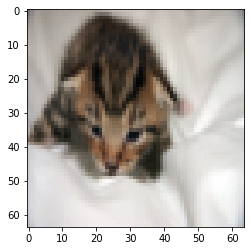

In [15]:
index = 1
result = model.predict(test_set_x_t).T
plt.imshow(test_set_x_orig[index])
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(round(result[0, index]))].decode("utf-8") +  "\" picture.")